# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [3]:
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [4]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

## Alphalens Analysis

In [5]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2014': ], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [8]:
predictions = pd.read_hdf('test_preds.h5', 'predictions').iloc[:, :3].mean(1).to_frame('prediction')

In [9]:
factor = (predictions
          .unstack('symbol')
          .asfreq('D')
          .dropna(how='all')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('symbol').unique()

In [10]:
trade_prices = pd.read_hdf('data.h5', 'trade_prices')

In [11]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21)).sort_index()
factor_data.info()

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 744805 entries, (2014-11-28 00:00:00+00:00, A) to (2017-11-29 00:00:00+00:00, ZION)
Data columns (total 6 columns):
1D                 744805 non-null float64
5D                 744805 non-null float64
10D                744805 non-null float64
21D                744805 non-null float64
factor             744805 non-null float32
factor_quantile    744805 non-null int64
dtypes: float32(1), float64(4), int64(1)
memory usage: 34.1+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036432,0.007562,-0.001324,0.002419,149130,20.022691
2,-0.008367,0.008533,-0.000017,0.002090,148881,19.989259
3,-0.007474,0.009942,0.000635,0.002055,148855,19.985768
4,-0.006745,0.011804,0.001316,0.002046,148881,19.989259
5,-0.005461,0.041306,0.002960,0.002679,149058,20.013024


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.094,0.045,0.052,0.045
beta,0.107,0.167,0.195,0.170
Mean Period Wise Return Top Quantile (bps),3.590,2.709,3.097,2.866
Mean Period Wise Return Bottom Quantile (bps),-4.375,-2.570,-2.970,-2.523
Mean Period Wise Spread (bps),7.965,5.255,6.036,5.362


Information Analysis


,1D,5D,10D,21D
IC Mean,0.012,0.023,0.038,0.050
IC Std.,0.136,0.147,0.147,0.134
Risk-Adjusted IC,0.091,0.154,0.257,0.371
t-stat(IC),2.488,4.244,7.073,10.195
p-value(IC),0.013,0.000,0.000,0.000
IC Skew,-0.281,-0.055,-0.134,-0.489
IC Kurtosis,7.615,10.347,10.052,5.260


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.682,0.562,0.750,0.630
Quantile 2 Mean Turnover,0.760,0.711,0.776,0.741
Quantile 3 Mean Turnover,0.774,0.737,0.784,0.760
Quantile 4 Mean Turnover,0.762,0.709,0.784,0.743
Quantile 5 Mean Turnover,0.634,0.516,0.693,0.588


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.459,0.345,0.257,0.139


<Figure size 432x288 with 0 Axes>

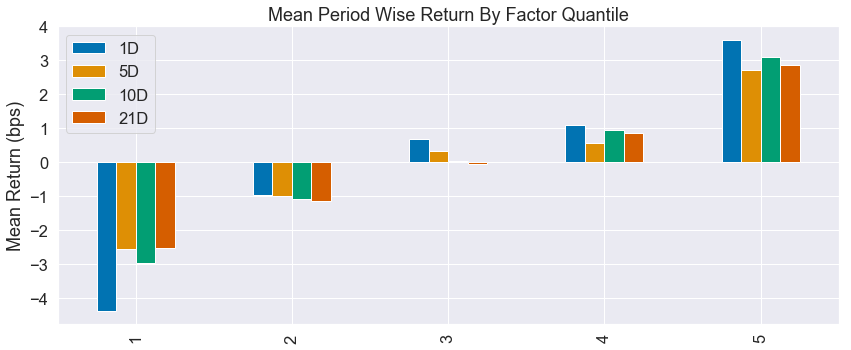

In [12]:
create_summary_tear_sheet(factor_data)

### Load zipline extensions

Only need this in notebook to find bundle.

In [14]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [15]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [16]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 10

## Load Data

### Quandl Wiki Bundel

In [17]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [18]:
def load_predictions(bundle):
    predictions = pd.read_hdf('test_preds.h5', 'predictions').iloc[:, :3].mean(1).to_frame('prediction')
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [19]:
predictions, assets = load_predictions(bundle_data)

In [20]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2014-11-28 to 2017-11-29
Columns: 995 entries, 0 to 3188
dtypes: float32(995)
memory usage: 2.9 MB


### Define Custom Dataset

In [21]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [22]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [23]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [24]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [25]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.longs = context.shorts = None
    set_slippage(slippage.FixedSlippage(spread=0.00))
#     set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [26]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    longs = pipeline_output('signals').longs.astype(int)
    shorts = pipeline_output('signals').shorts.astype(int)
    holdings = context.portfolio.positions.keys()
    
    if longs.sum() > MIN_POSITIONS and shorts.sum() > MIN_POSITIONS:
        context.longs = longs[longs!=0].index
        context.shorts = shorts[shorts!=0].index
        context.divest = holdings - set(context.longs) - set(context.shorts)
    else:
        context.longs = context.shorts = pd.Index([])
        context.divest = set(holdings)

## Define Rebalancing Logic

In [27]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
          
    for stock in context.divest:
        order_target(stock, target=0)
    
#     log.warning('{} {:,.0f}'.format(len(context.portfolio.positions), context.portfolio.portfolio_value))
    if not (context.longs.empty and context.shorts.empty):
        for stock in context.shorts:
            order_target_percent(stock, -1 / len(context.shorts))
        for stock in context.longs:
            order_target_percent(stock, 1 / len(context.longs))

## Record Data Points

In [28]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [29]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [30]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2014-11-28
End:   2017-11-29


In [31]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-03-18 00:12:45.817307]: WARNING: ensure_benchmark_data: Still don't have expected benchmark data for 'SPY' from 1989-12-29 00:00:00+00:00 to 2020-03-18 00:00:00+00:00 after redownload!
[2020-03-18 00:12:46.502899]: WARNING: ensure_treasury_data: Still don't have expected treasury data for 'SPY' from 1990-01-02 00:00:00+00:00 to 2020-03-18 00:00:00+00:00 after redownload!


Duration: 40.39s


## PyFolio Analysis

In [32]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [33]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

In [34]:
LIVE_DATE = '2016-11-30'

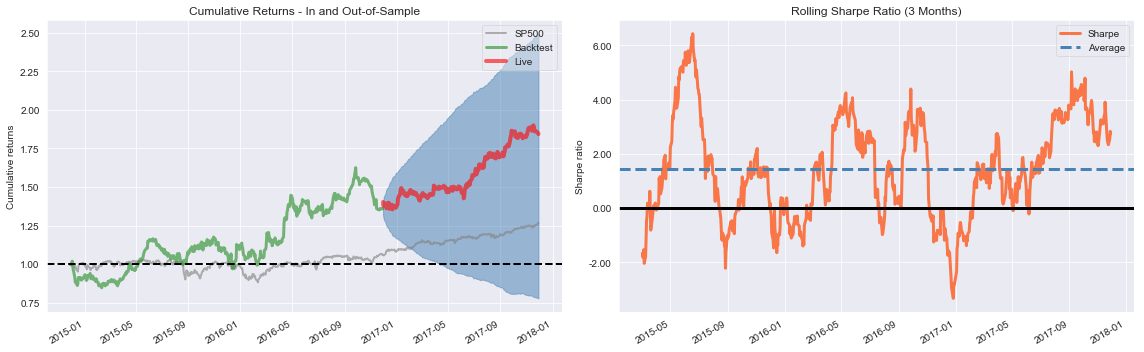

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig('figures/pyfolio_out_of_sample', dpi=300);

### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.54,2015-10-30,2015-12-14,2016-03-03,90
1,16.92,2014-12-03,2015-02-10,2015-05-11,114
2,16.83,2016-09-27,2016-11-21,2017-07-13,208
3,14.48,2015-06-10,2015-08-19,2015-10-30,103
4,10.17,2016-04-28,2016-06-16,2016-08-08,73


Stress Events,mean,min,max
Fall2015,0.33%,-2.41%,4.10%
New Normal,0.09%,-4.73%,8.17%


Top 10 long positions of all time,max
sid,
ESV,7.75%
KRO,7.51%
WMB,7.43%
NEM,7.21%
WDC,7.20%
WYNN,7.10%
FIZZ,7.05%
ARRY,7.00%
BOFI,6.95%


Top 10 short positions of all time,max
sid,
MDCO,-9.55%
AFSI,-9.55%
OAS,-9.52%
SBRA,-9.39%
SEE,-9.38%
TDS,-9.37%
VMC,-9.32%
USM,-9.30%
ACM,-9.29%


Top 10 positions of all time,max
sid,
MDCO,9.55%
AFSI,9.55%
OAS,9.52%
SBRA,9.39%
SEE,9.38%
TDS,9.37%
VMC,9.32%
USM,9.30%
ACM,9.29%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,26226.00,13758.00,12468.00
Percent profitable,0.50,0.47,0.53
Winning round_trips,13120.00,6511.00,6609.00
Losing round_trips,12961.00,7174.00,5787.00
Even round_trips,145.00,73.00,72.00


PnL stats,All trades,Short trades,Long trades
Total profit,$82553.08,$-55243.88,$137796.96
Gross profit,$1511512.80,$642266.66,$869246.14
Gross loss,$-1428959.72,$-697510.54,$-731449.18
Profit factor,$1.06,$0.92,$1.19
Avg. trade net profit,$3.15,$-4.02,$11.05
Avg. winning trade,$115.21,$98.64,$131.52
Avg. losing trade,$-110.25,$-97.23,$-126.40
Ratio Avg. Win:Avg. Loss,$1.04,$1.01,$1.04
Largest winning trade,$2903.72,$1976.16,$2903.72
Largest losing trade,$-3591.98,$-2098.11,$-3591.98


Duration stats,All trades,Short trades,Long trades
Avg duration,3 days 06:47:26.122168,3 days 04:52:12.402965,3 days 08:54:35.168431
Median duration,2 days 21:00:00,2 days 00:00:00,3 days 00:00:00
Longest duration,288 days 23:00:00,143 days 23:00:00,288 days 23:00:00
Shortest duration,0 days 21:00:00,0 days 21:00:00,0 days 21:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.01%
Avg returns winning,0.09%,0.08%,0.10%
Avg returns losing,-0.09%,-0.08%,-0.10%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.05%,0.05%,0.06%
Median returns losing,-0.05%,-0.05%,-0.06%
Largest winning trade,2.47%,1.97%,2.47%
Largest losing trade,-3.35%,-1.82%,-3.35%


Symbol stats,A,AAL,AAN,AAP,AAPL,ABC,ABMD,ABT,ACC,ACGL,ACIW,ACM,ACN,ACXM,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEL,AEO,AEP,AES,AET,AFG,AFL,AFSI,AGCO,AGN,AGNC,AGO,AHL,AIG,AIT,AIV,AIZ,AJG,AKAM,ALB,ALE,ALGN,ALK,ALKS,ALL,ALNY,ALXN,AMAT,AMD,AME,AMED,AMG,AMGN,AMP,AMT,AMTD,AMZN,AN,ANAT,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,ARE,ARNC,ARRS,ARRY,ARW,ASGN,ASH,ATHN,ATI,ATO,ATR,ATVI,AVA,AVB,AVGO,AVT,AVX,AVY,AWI,AWK,AXP,AXS,AYI,AZO,AZPN,B,BA,BAC,BAH,BAX,BBBY,BBT,BBY,BC,BCO,BCPC,BDC,BDN,BDX,BECN,BEN,BG,BGCP,BID,BIDU,BIIB,BIO,BK,BKH,BLK,BLKB,BLL,BMRN,BMS,BMY,BOFI,BOH,BOKF,BP,BPOP,BR,BRKR,BRO,BSX,BWA,BXP,BXS,BYD,C,CA,CACC,CACI,CAG,CAH,CAKE,CAR,CASY,CAT,CATY,CAVM,CB,CBOE,CBRL,CBSH,CBT,CBU,CCE,CCI,CCK,CCL,CCMP,CCOI,CDNS,CE,CELG,CERN,CF,CFR,CFX,CGNX,CHD,CHDN,CHE,CHFC,CHH,CHK,CHKP,CHRW,CHTR,CI,CIEN,CIM,CINF,CIT,CL,CLF,CLGX,CLH,CLNY,CLR,CLX,CMA,CMC,CMCSA,CME,CMG,CMI,CMS,CNA,CNC,CNK,CNO,CNP,CNX,COF,COG,COHR,COL,COLB,COLM,COO,COP,COR,COST,CPA,CPB,CPRT,CPT,CR,CREE,CRI,CRL,CRM,CRS,CSCO,CSFL,CSGP,CSL,CSX,CTAS,CTL,CTSH,CTXS,CUBE,CUZ,CVBF,CVI,CVLT,CVS,CVX,CW,CXO,CXW,CY,D,DAL,DAN,DAR,DCI,DCT,DDS,DE,DECK,DEI,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DK,DKS,DLB,DLR,DLTR,DLX,DNB,DO,DOV,DOX,DPS,DPZ,DRE,DRH,DRI,DTE,DUK,DVA,DVN,DXCM,DY,EA,EBAY,EBIX,EBS,ECL,ED,EDR,EE,EEFT,EFX,EGN,EGP,EIX,EL,ELS,EME,EMN,EMR,ENR,ENS,ENTG,ENV,EOG,EPR,EQIX,EQR,EQT,ERIE,ES,ESGR,ESRX,ESS,ESV,ETFC,ETN,ETR,EV,EVR,EW,EWBC,EXAS,EXC,EXEL,EXP,EXPD,EXPE,EXPO,EXR,F,FAF,FAST,FCFS,FCNCA,FCX,FDS,FDX,FE,FFBC,FFIN,FFIV,FHN,FIBK,FICO,FIS,FISV,FITB,FIZZ,FL,FLIR,FLO,FLR,FLS,FLT,FMBI,FMC,FNB,FNF,FNGN,FOLD,FOX,FOXA,FR,FRT,FSLR,FTI,FTNT,FUL,FULT,G,GBCI,GD,GDOT,GE,GEO,GGG,GGP,GHC,GILD,GIS,GLNG,GLW,GM,GNRC,GNTX,GOLD,GOOGL,GPC,GPK,GPN,GPS,GPT,GRA,GRMN,GS,GT,GTT,GVA,GWR,GWW,H,HAE,HAIN,HAL,HALO,HAS,HBAN,HBI,HCP,HCSG,HD,HE,HEI,HELE,HES,HFC,HHC,HI,HIG,HIW,HLF,HOG,HOLX,HOMB,HON,HP,HPP,HPQ,HPT,HR,HRB,HRC,HRG,HRL,HRS,HRTX,HSIC,HST,HSY,HUM,HUN,HXL,IART,IBKC,IBKR,IBM,IBOC,ICE,ICUI,IDA,IDCC,IDTI,IDXX,IEX,IFF,IGT,IIVI,ILMN,IMMU,INCY,INGR,INTC,INTU,IP,IPG,IPGP,IR,IRM,IRWD,ISBC,ISRG,IT,ITRI,ITT,ITW,IVZ,JACK,JBHT,JBL,JBLU,JBT,JCI,JCOM,JEC,JJSF,JKHY,JLL,JNJ,JNPR,JPM,JWN,K,KAR,KBR,KEX,KEY,KFY,KIM,KLAC,KMB,KMPR,KMT,KMX,KNX,KO,KR,KRC,KRO,KS,KSS,KSU,KW,L,LAMR,LANC,LAZ,LB,LBTYA,LDOS,LEA,LECO,LEG,LEN,LFUS,LGND,LH,LHCG,LHO,LII,LKQ,LLL,LLY,LM,LMT,LNC,LNG,LNT,LOGM,LOPE,LOW,LPLA,LPX,LRCX,LSI,LSTR,LUV,LVS,LYB,LYV,M,MA,MAA,MAC,MAN,MANH,MAR,MAS,MASI,MAT,MBFI,MCD,MCHP,MCK,MCO,MCY,MD,MDCO,MDLZ,MDP,MDR,MDSO,MDT,MDU,MET,MFA,MGLN,MGM,MHK,MIDD,MKC,MKL,MKSI,MKTX,MLM,MMC,MMM,MMS,MMSI,MNST,MO,MOH,MORN,MOS,MPW,MPWR,MRK,MRO,MRVL,MS,MSA,MSCI,MSFT,MSG,MSI,MSM,MTB,MTD,MTG,MTN,MTX,MTZ,MU,MUR,MXIM,MYGN,MYL,NATI,NAV,NBIX,NBL,NCR,NDAQ,NDSN,NEE,NEM,NEOG,NEU,NFG,NFLX,NFX,NHI,NI,NJR,NKE,NKTR,NLY,NNI,NOC,NOV,NRG,NSC,NSP,NTAP,NTCT,NTRS,NUAN,NUE,NUS,NUVA,NVDA,NVR,NWE,NWL,NXST,NYCB,NYT,O,OAS,OC,ODFL,OFC,OGE,OHI,OI,OII,OKE,OLED,OLN,OMC,ONB,OPK,ORA,ORCL,ORI,ORLY,OSK,OXY,OZRK,PACW,PAG,PAY,PAYX,PB,PBCT,PCAR,PCG,PCH,PDCE,PDM,PEB,PEG,PEGA,PENN,PEP,PFE,PFG,PG,PGR,PH,PHM,PII,PKG,PKI,PLD,PLT,PM,PNC,PNFP,PNM,PNR,PNW,PODD,POL,POOL,POR,PPC,PPG,PPL,PRGO,PRI,PRU,PSA,PSB,PSMT,PTEN,PVH,PWR,PX,PXD,QCOM,QDEL,QGEN,R,RBC,RCL,RDN,RE,REG,REGN,RES,RF,RGA,RGLD,RHI,RHP,RHT,RIG,RJF,RL,RLI,RMD,RNR,ROK,ROL,ROLL,ROP,ROST,RP,RPM,RRC,RS,RSG,RTN,RYN,S,SAM,SATS,SBAC,SBGI,SBNY,SBRA,SBUX,SCCO,SCG,SCHW,SCI,SE,SEB,SEE,SEIC,SEM,SF,SFLY,SFNC,SGEN,SGMS,SHO,SHOO,SHW,SIG,SIGI,SIRI,SIVB,SIX,SJI,SJM,SKX,SKYW,SLAB,SLB,SLG,SLGN,SLM,SM,SMG,SMTC,SNA,SNH,SNPS,SNV,SNX,SO,SON,SPG,SPR,SRCL,SRE,SSD,SSNC,STE,STI,STL,STLD,STMP,STT,STWD,STX,STZ,SUI,SWK,SWKS,SWN,SWX,SXT,SYK,SYMC,SYNT,SYY,T,TAL,TAP,TCBI,TCO,TDC,TDG,TDS,TDY,TECD,TECH,TEL,TER,TEX,TFSL,TFX,TGT,THC,THG,THO,THS,TIF,TJX,TKR,TMK,TMO,TMUS,TOL,TPX,TREE,TREX,TRGP,TRI,TRMB,TRN,TROW,TROX,TRV,TSCO,TSLA,TSN,TSS,TTC,TTEK,TTWO,TWO,TXN,TXRH,TXT,TYL,UAA,UAL,UBSH,UBSI,UCBI,UDR,UFS,UGI,UHAL,UHS,ULTA,ULTI,UMBF,UMPQ,UNF,UNH,UNM,UNP,UPS,URBN,URI,USB,USG,USM,USNA,UTHR,UTX,V,VAR,VC,VFC,VG,VGR,VIAB,VLO,VLY,VMC,VMI,VMW,VNO,VOD,VR,VRNT,VRSK,VRSN,VRTX,VRX,VSAT,VSH,VTR,VVC,VZ,WAB,WAFD,WAL,WAT,W

Profitability (PnL / PnL total) per name,
symbol,
TROX,9.71%
ARRY,6.54%
WMB,6.04%
IMMU,5.98%
GLNG,5.27%
CLF,5.12%
NKTR,4.78%
RRC,4.07%
AMD,4.02%


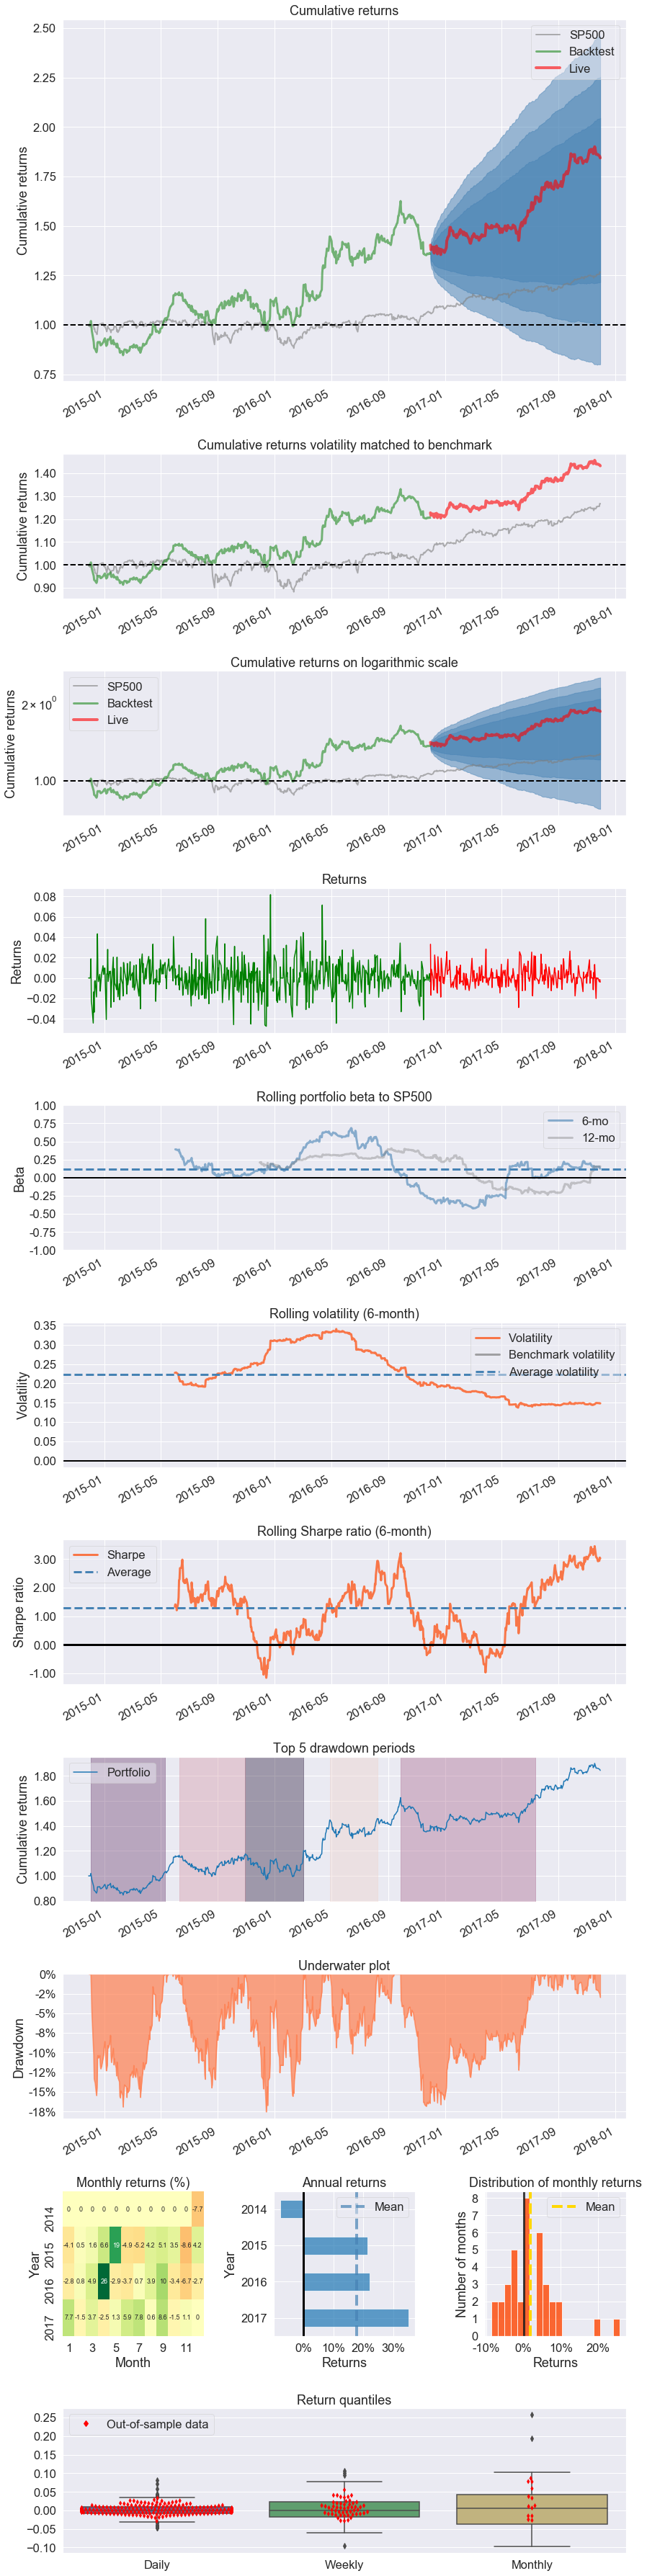

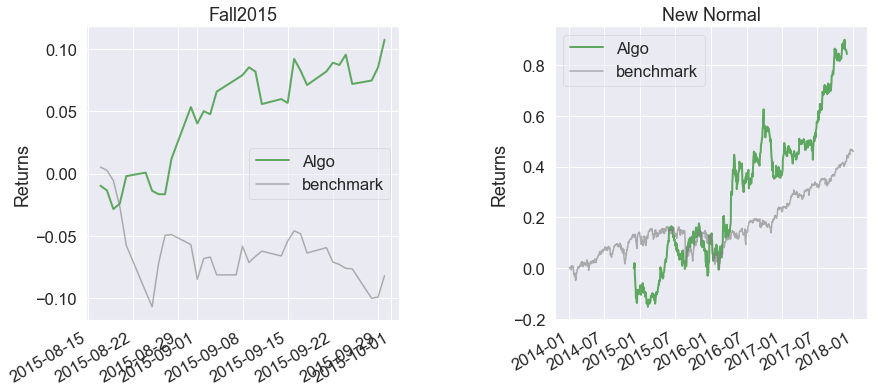

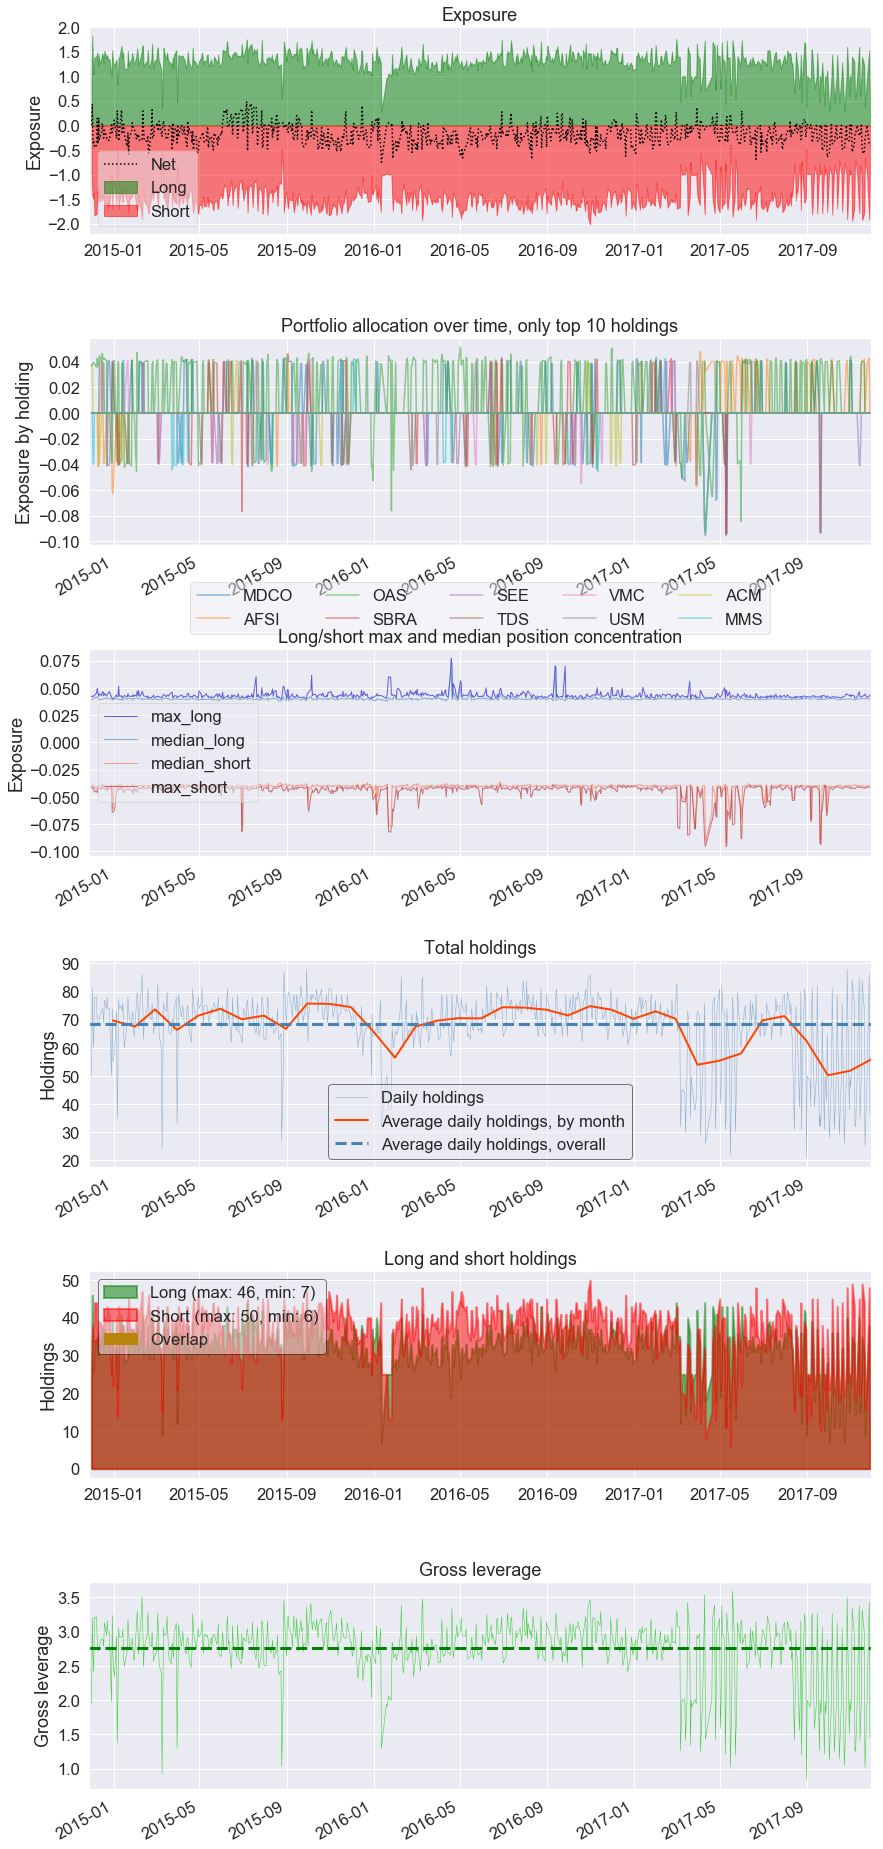

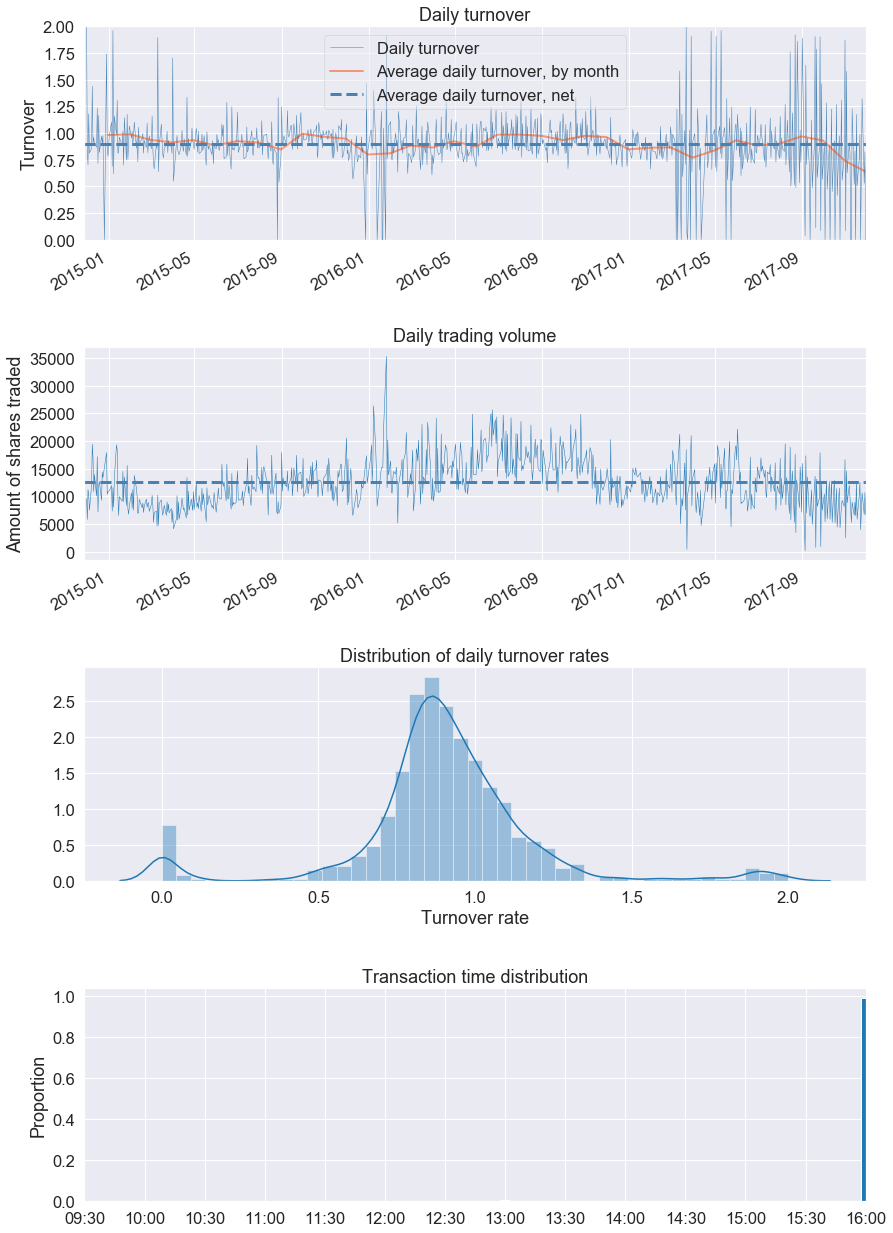

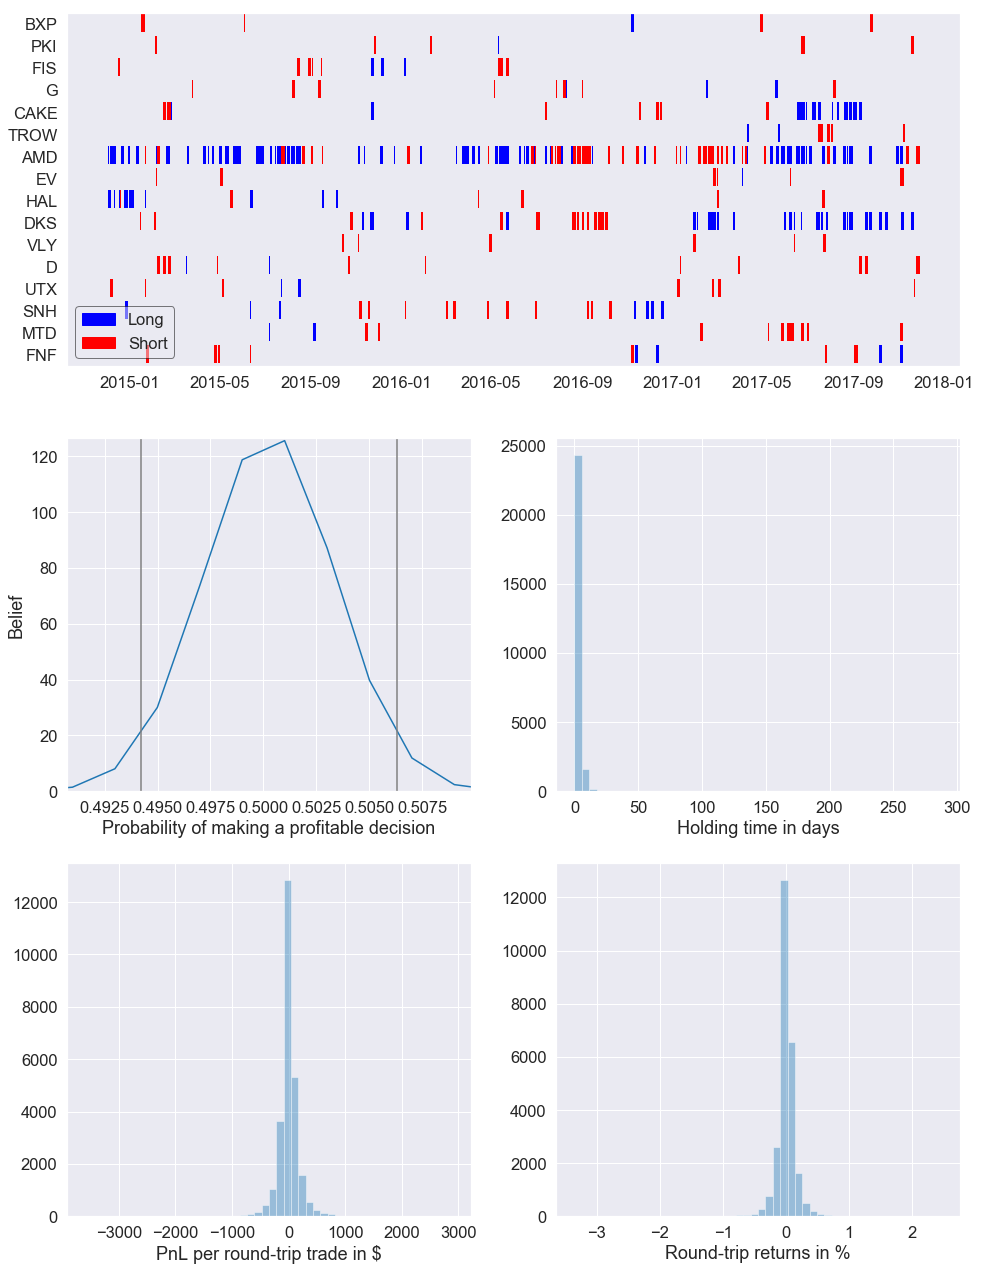

In [36]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date=LIVE_DATE, 
                          round_trips=True)